In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm as tqdm
import time 
import math

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, AdaBoostClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.svm import SVC

## Section 3: Cleaning weather.csv for combination with train and test data

### Part 3.1: Cleaning weather.csv

The weather data has useful information that can be combined with the training and test data. Let's first clean the weather data so that they can be combined with train and test data.

In [2]:
weather = pd.read_csv('../assets/west_nile/input/weather.csv')
train = pd.read_csv('../assets/west_nile/input/train.csv')
test = pd.read_csv('../assets/west_nile/input/test.csv')

In [3]:
#Drop the columns we don't want, including Sunrise and Sunset and PrecipTotal. For now, remove CodeSum.
weather.drop(columns=['Depth', 'Water1', 'SnowFall', 'Heat', 'Sunrise', 'Sunset', 'PrecipTotal', 'CodeSum'], inplace=True)

In [4]:
#Define a function to replace Missing values with the median and converting the result to a float64
def clean_column(string):
    weather[string][weather[string]=='M'] = weather[string][weather[string]!='M'].median()
    weather[string][weather[string]=='T'] = weather[string][weather[string]!='T'].median()
    weather[string] = weather[string].astype('float64')
    return weather

In [5]:
#Clean all the columns from the previous EDA notebook
clean_column('Tavg')
clean_column('Cool')
clean_column('Depart')
clean_column('SeaLevel')
clean_column('AvgSpeed')
clean_column('StnPressure')
clean_column('WetBulb');

<ipython-input-4-017c55ef185c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather[string][weather[string]=='M'] = weather[string][weather[string]!='M'].median()
<ipython-input-4-017c55ef185c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather[string][weather[string]=='T'] = weather[string][weather[string]!='T'].median()


In [6]:
#Convert the 'Date' column to a datetime so that they can be combined together
train['Date'] = pd.to_datetime(train['Date'])
weather['Date'] = pd.to_datetime(weather['Date'])
test['Date'] = pd.to_datetime(test['Date'])

In [7]:
#Reset the index and replace them with the date
train.reset_index(drop = True, inplace = True)
weather.reset_index(drop = True, inplace = True)
test.reset_index(drop = True, inplace = True)

train.set_index('Date', inplace = True)
weather.set_index('Date', inplace = True)
test.set_index('Date', inplace = True)

In [8]:
weather.dtypes

Station          int64
Tmax             int64
Tmin             int64
Tavg           float64
Depart         float64
DewPoint         int64
WetBulb        float64
Cool           float64
StnPressure    float64
SeaLevel       float64
ResultSpeed    float64
ResultDir        int64
AvgSpeed       float64
dtype: object

### Part 3.2: Combining weather.csv with train.csv and test.csv

You may wonder if combining weather data with train and test csv will somehow contaminate the one with the other. However, train and test data are for different years. This means that train.csv will get weather data for 2007, 2009, 2011, and 2013, while test.csv will get weather data for 2008, 2010, 2012, and 2014. They will simply be augmented with the appropriate weather data.

In [9]:
#Combining the two together
weather_train_df = train.join(weather[weather['Station']==1])
weather_test_df = test.join(weather[weather['Station']==1])

In [10]:
#Let's do a sanity check to ensure that the length of the datasets are the same
print(f"Length of training dataset: {len(train)}")
print(f"Length of combined weather and training dataset: {len(weather_train_df)}")
print()
print(f"Length of test dataset: {len(test)}")
print(f"Length of combined weather and test dataset: {len(weather_test_df)}")

Length of training dataset: 10506
Length of combined weather and training dataset: 10506

Length of test dataset: 116293
Length of combined weather and test dataset: 116293


Drop the 'Station' column from both datasets and drop 'NumMosquitos' from weather_train_df,since that information is not available in weather_test_df

In [11]:
#Dropping the columns
weather_train_df.drop(columns = ['NumMosquitos', 'Station', 'Trap'], inplace=True)
weather_test_df.drop(columns = ['Station', 'Trap'], inplace=True)

In [12]:
weather_train_df.head()

,Address,Species,Block,Street,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,WnvPresent,Tmax,...,Tavg,Depart,DewPoint,WetBulb,Cool,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
Date,,,,,,,,,,,,,,,,,,,,,
2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,0,88,...,74.0,10.0,58,65.0,9.0,29.39,30.11,5.8,18,6.5
2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,0,88,...,74.0,10.0,58,65.0,9.0,29.39,30.11,5.8,18,6.5
2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,0,88,...,74.0,10.0,58,65.0,9.0,29.39,30.11,5.8,18,6.5
2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,0,88,...,74.0,10.0,58,65.0,9.0,29.39,30.11,5.8,18,6.5
2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,0,88,...,74.0,10.0,58,65.0,9.0,29.39,30.11,5.8,18,6.5


In [13]:
weather_test_df.head()

,Id,Address,Species,Block,Street,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,Tmax,...,Tavg,Depart,DewPoint,WetBulb,Cool,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
Date,,,,,,,,,,,,,,,,,,,,,
2008-06-11,1,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,86,...,74.0,7.0,56,64.0,9.0,29.28,29.99,8.9,18,10.0
2008-06-11,2,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,86,...,74.0,7.0,56,64.0,9.0,29.28,29.99,8.9,18,10.0
2008-06-11,3,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS,41,N OAK PARK AVE,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,86,...,74.0,7.0,56,64.0,9.0,29.28,29.99,8.9,18,10.0
2008-06-11,4,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX SALINARIUS,41,N OAK PARK AVE,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,86,...,74.0,7.0,56,64.0,9.0,29.28,29.99,8.9,18,10.0
2008-06-11,5,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX TERRITANS,41,N OAK PARK AVE,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,86,...,74.0,7.0,56,64.0,9.0,29.28,29.99,8.9,18,10.0


In [14]:
#Convert species into dummy variables, applying the same list to the test set too
#Taken from 
# https://stackoverflow.com/questions/37425961/dummy-variables-when-not-all-categories-are-present/37451867#37451867
possible_categories = set(list(weather_train_df['Species']))

#Convert the species in train data to dummies
species_train = pd.get_dummies(weather_train_df['Species'].astype(pd.CategoricalDtype(categories=possible_categories)), drop_first= True)
species_train


,CULEX PIPIENS/RESTUANS,CULEX ERRATICUS,CULEX TERRITANS,CULEX SALINARIUS,CULEX PIPIENS,CULEX TARSALIS
Date,,,,,,
2007-05-29,1,0,0,0,0,0
2007-05-29,0,0,0,0,0,0
2007-05-29,0,0,0,0,0,0
2007-05-29,1,0,0,0,0,0
2007-05-29,0,0,0,0,0,0
...,...,...,...,...,...,...
2013-09-26,1,0,0,0,0,0
2013-09-26,1,0,0,0,0,0
2013-09-26,1,0,0,0,0,0


In [15]:
#Convert the species in test data to dummies
species_test = pd.get_dummies(weather_test_df['Species'].astype(pd.CategoricalDtype(categories=possible_categories)), drop_first= True)
species_test

,CULEX PIPIENS/RESTUANS,CULEX ERRATICUS,CULEX TERRITANS,CULEX SALINARIUS,CULEX PIPIENS,CULEX TARSALIS
Date,,,,,,
2008-06-11,1,0,0,0,0,0
2008-06-11,0,0,0,0,0,0
2008-06-11,0,0,0,0,1,0
2008-06-11,0,0,0,1,0,0
2008-06-11,0,0,1,0,0,0
...,...,...,...,...,...,...
2014-10-02,0,0,0,1,0,0
2014-10-02,0,0,1,0,0,0
2014-10-02,0,0,0,0,0,1


In [16]:
#Concatenating the data together and dropping the original 'Species' column
weather_train_df = pd.concat([weather_train_df, species_train], axis=1)
weather_train_df.drop(columns='Species', inplace=True)

weather_test_df = pd.concat([weather_test_df, species_test], axis=1)
weather_test_df.drop(columns='Species', inplace=True);

In [17]:
X = weather_train_df[weather_train_df.columns.difference(['WnvPresent', 'Id', 'Address', 'Block', 'Street', 'AddressNumberAndStreet'])]
y = weather_train_df['WnvPresent']
X

,AddressAccuracy,AvgSpeed,CULEX ERRATICUS,CULEX PIPIENS,CULEX PIPIENS/RESTUANS,CULEX SALINARIUS,CULEX TARSALIS,CULEX TERRITANS,Cool,Depart,...,Latitude,Longitude,ResultDir,ResultSpeed,SeaLevel,StnPressure,Tavg,Tmax,Tmin,WetBulb
Date,,,,,,,,,,,,,,,,,,,,,
2007-05-29,9,6.5,0,0,1,0,0,0,9.0,10.0,...,41.954690,-87.800991,18,5.8,30.11,29.39,74.0,88,60,65.0
2007-05-29,9,6.5,0,0,0,0,0,0,9.0,10.0,...,41.954690,-87.800991,18,5.8,30.11,29.39,74.0,88,60,65.0
2007-05-29,9,6.5,0,0,0,0,0,0,9.0,10.0,...,41.994991,-87.769279,18,5.8,30.11,29.39,74.0,88,60,65.0
2007-05-29,8,6.5,0,0,1,0,0,0,9.0,10.0,...,41.974089,-87.824812,18,5.8,30.11,29.39,74.0,88,60,65.0
2007-05-29,8,6.5,0,0,0,0,0,0,9.0,10.0,...,41.974089,-87.824812,18,5.8,30.11,29.39,74.0,88,60,65.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-09-26,8,4.2,0,0,1,0,0,0,0.0,3.0,...,41.763733,-87.742302,8,3.8,30.04,29.34,63.0,75,50,58.0
2013-09-26,8,4.2,0,0,1,0,0,0,0.0,3.0,...,41.987280,-87.666066,8,3.8,30.04,29.34,63.0,75,50,58.0
2013-09-26,9,4.2,0,0,1,0,0,0,0.0,3.0,...,41.912563,-87.668055,8,3.8,30.04,29.34,63.0,75,50,58.0


In [18]:
#Also drop the columns from weather_test_df for later use
weather_test_modified_df = weather_test_df[weather_test_df.columns.difference(['Id', 'Address', 'Block', 'Street', 'AddressNumberAndStreet'])]
weather_test_modified_df

,AddressAccuracy,AvgSpeed,CULEX ERRATICUS,CULEX PIPIENS,CULEX PIPIENS/RESTUANS,CULEX SALINARIUS,CULEX TARSALIS,CULEX TERRITANS,Cool,Depart,...,Latitude,Longitude,ResultDir,ResultSpeed,SeaLevel,StnPressure,Tavg,Tmax,Tmin,WetBulb
Date,,,,,,,,,,,,,,,,,,,,,
2008-06-11,9,10.0,0,0,1,0,0,0,9.0,7.0,...,41.954690,-87.800991,18,8.9,29.99,29.28,74.0,86,61,64.0
2008-06-11,9,10.0,0,0,0,0,0,0,9.0,7.0,...,41.954690,-87.800991,18,8.9,29.99,29.28,74.0,86,61,64.0
2008-06-11,9,10.0,0,1,0,0,0,0,9.0,7.0,...,41.954690,-87.800991,18,8.9,29.99,29.28,74.0,86,61,64.0
2008-06-11,9,10.0,0,0,0,1,0,0,9.0,7.0,...,41.954690,-87.800991,18,8.9,29.99,29.28,74.0,86,61,64.0
2008-06-11,9,10.0,0,0,0,0,0,1,9.0,7.0,...,41.954690,-87.800991,18,8.9,29.99,29.28,74.0,86,61,64.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-10-02,8,7.9,0,0,0,1,0,0,3.0,10.0,...,41.925652,-87.633590,17,7.2,29.78,29.03,68.0,72,63,63.0
2014-10-02,8,7.9,0,0,0,0,0,1,3.0,10.0,...,41.925652,-87.633590,17,7.2,29.78,29.03,68.0,72,63,63.0
2014-10-02,8,7.9,0,0,0,0,1,0,3.0,10.0,...,41.925652,-87.633590,17,7.2,29.78,29.03,68.0,72,63,63.0


In [19]:
X_train, X_test, y_train, y_test = train_test_split (X, y, stratify = y, random_state = 42)

In [20]:
len(X_train)

7879

In [21]:
len(X_test)

2627

In [22]:
len(y_train)

7879

In [23]:
X_train.head()

,AddressAccuracy,AvgSpeed,CULEX ERRATICUS,CULEX PIPIENS,CULEX PIPIENS/RESTUANS,CULEX SALINARIUS,CULEX TARSALIS,CULEX TERRITANS,Cool,Depart,...,Latitude,Longitude,ResultDir,ResultSpeed,SeaLevel,StnPressure,Tavg,Tmax,Tmin,WetBulb
Date,,,,,,,,,,,,,,,,,,,,,
2013-09-06,8,6.0,0,1,0,0,0,0,7.0,5.0,...,41.743402,-87.731435,20,4.7,30.11,29.38,72.0,86,57,64.0
2011-09-12,9,10.9,0,1,0,0,0,0,10.0,10.0,...,41.899230,-87.716788,23,10.5,29.91,29.18,75.0,86,64,65.0
2011-09-30,9,15.0,0,0,1,0,0,0,0.0,-8.0,...,41.766202,-87.562889,34,14.6,30.01,29.32,51.0,57,45,47.0
2007-08-22,5,9.5,0,1,0,0,0,0,15.0,9.0,...,41.726465,-87.585413,21,5.3,29.94,29.23,80.0,90,69,73.0
2007-07-18,8,10.1,0,1,0,0,0,0,12.0,3.0,...,41.862292,-87.648860,24,9.1,29.84,29.11,77.0,85,69,71.0


## Section 4: Modelling and Predicting

### Part 4.1: Modelling using several classifiers

In this section, we predict using K-nearest neighbors, logisitic regression, random forest, support vector machines, and adaboost.

In [24]:
# First, define a simple function to score a give model with the ROC AUC score
# this function is taken from : https://github.com/doyleax/West-Nile-Virus-Prediction/blob/master/Final-NB.ipynb
def score_model(model,X_test,y_test):
    preds = model.predict_proba(X_test)
    pred_list =[]
    
    for x in preds:
        pred_list.append(x[1])
        
    roc_score = roc_auc_score(y_test, pred_list)
    return roc_score

In [25]:
#Scale the X_train and X_test data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### SVM
- Support Vector Machine is a linear model for classification and regression problems. It can solve linear and non-linear problems and work well for many practical problems. 
- SVM creates a line or a hyperplane which separates the data into classes.
- They can be applied to both linear and non linear problems, and they are one of the best general purpose algorithm for machine learning inferior only to neural net and deep learning.

In [26]:
svmc= SVC(probability=True, random_state=42)
svm_model = svmc.fit(X_train,y_train)
print(f"svm training score: {score_model(svm_model,X_train, y_train)}")
print(f"svm test score: {score_model(svm_model,X_test,y_test)}")


svm training score: 0.9101033644693718
svm test score: 0.7521383944427946


In [27]:
# clf = LogisticRegression()
# clf.fit(X_train, y_train)
# THRESHOLD = 0.25
# y_pred = np.where(clf.predict_proba(X_test)[:,1] >= THRESHOLD, 1, 0)
# y_pred_proba_new_threshold = (clf.predict_proba(X_test)[:,1] >= THRESHOLD).astype(int)

### Adaboost
- For Adaboost, the weights are re-assigned to each instance, with higher weights to incorrectly classified instances. 
- AdaBoost is used to boost the performance of decision trees on binary classification problems, thus, it is relevant in our case

In [28]:
#List Hyperparameters that we want to tune.
random_state = [42]
n_estimators = list(range(35,45))
learning_rate = [0.05, 0.1, 0.5, 1, 2]

#Convert to dictionary
hyperparameters = dict(random_state=random_state, n_estimators = n_estimators, learning_rate = learning_rate)

#Create new KNN object
adaboost = AdaBoostClassifier()

#Use GridSearch
ada_boost = GridSearchCV(adaboost, hyperparameters, cv=10)

#Fit the model
ada_model = ada_boost.fit(X_train,y_train)#Print The value of best Hyperparameters

print('Best learning_rate:', ada_model.best_estimator_.get_params()['learning_rate'])
print('Best n_estimators', ada_model.best_estimator_.get_params()['n_estimators'])
print()
print(f"adaboost training score: {score_model(ada_model,X_train, y_train)}")
print(f"adaboost test score: {score_model(ada_model,X_test,y_test)}")

Best learning_rate: 0.05
Best n_estimators 35

adaboost training score: 0.7199631063565646
adaboost test score: 0.7078740661810516


### KNN
- KNN is a simple, supervised machine learning algorithm that can be used to solve both classification and regression problems.
- However, it is more widely used in classification problems in the industry, thus it is useful in our case.

In [29]:
#Taken from https://medium.com/datadriveninvestor/k-nearest-neighbors-in-python-hyperparameters-tuning-716734bc557f

#List Hyperparameters that we want to tune.
leaf_size = list(range(30,40))
n_neighbors = list(range(21,29))

#Convert to dictionary
hyperparameters = dict(leaf_size=leaf_size, n_neighbors=n_neighbors)

#Create new KNN object
knn = KNeighborsClassifier()

#Use GridSearch
clf = GridSearchCV(knn, hyperparameters, cv=10)

#Fit the model
knn_model = clf.fit(X_train,y_train)#Print The value of best Hyperparameters

print('Best leaf_size:', knn_model.best_estimator_.get_params()['leaf_size'])
print('Best n_neighbors:', knn_model.best_estimator_.get_params()['n_neighbors'])
print()
print(f"knn training score: {score_model(knn_model,X_train, y_train)}")
print(f"knn test score: {score_model(knn_model,X_test,y_test)}")

Best leaf_size: 30
Best n_neighbors: 21

knn training score: 0.8805213173002518
knn test score: 0.7668917148496864


### Logistic Regression and Randomforest

In [30]:
steps =  [ #list of pipeline steps for each model  
    [('logreg',LogisticRegression())],
    [('rainforest', RandomForestClassifier())]
    ]

pipe_titles = ['logreg', 'rf']

grid_results = pd.DataFrame(columns=['step','train_accuracy', 'test_accuracy', 'roc','tn','fp','fn','tp'])


In [31]:
for i in (range(len(steps))):          
    pipe = Pipeline(steps=steps[i])         # configure pipeline for each model
    grid = pipe
    model_results = {}
    
    grid.fit(X_train, y_train)

    
    print('Step: ',pipe_titles[i])
    model_results['step'] = pipe_titles[i]


    #Score the model on training set
    print(f"training score: {grid.score(X_train, y_train)}", '\n')
    model_results['train_accuracy'] = grid.score(X_train, y_train)
    
    #Score the model on test set
    print(f"test score: {grid.score(X_test, y_test)}", '\n')
    model_results['test_accuracy'] = grid.score(X_test, y_test)
    
    #Score the model on auc_roc
    print(f"auc_roc score: {score_model(pipe,X_test, y_test)}", '\n')
    model_results['roc'] = score_model(pipe,X_test, y_test)

    # Display the confusion matrix results showing true/false positive/negative
    tn, fp, fn, tp = confusion_matrix(y_test, grid.predict(X_test)).ravel() 

    print("True Negatives: %s" % tn)
    model_results['tn'] = tn

    print("False Positives: %s" % fp)  
    model_results['fp'] = fp

    print("False Negatives: %s" % fn)
    model_results['fn'] = fn

    print("True Positives: %s" % tp, '\n')
    model_results['tp'] = tp

    grid_results = grid_results.append(model_results, ignore_index=True)

Step:  logreg
training score: 0.9475821804797563 

test score: 0.9474685953559193 

auc_roc score: 0.7274995487390896 

True Negatives: 2489
False Positives: 0
False Negatives: 138
True Positives: 0 

Step:  rf
training score: 0.9838812031983755 

test score: 0.9398553483060526 

auc_roc score: 0.7492110212471106 

True Negatives: 2450
False Positives: 39
False Negatives: 119
True Positives: 19 



In [32]:
grid_results

,step,train_accuracy,test_accuracy,roc,tn,fp,fn,tp
0,logreg,0.947582,0.947469,0.727500,2489,0,138,0
1,rf,0.983881,0.939855,0.749211,2450,39,119,19


#### Analysing the models

All the models have had good results on the training set, scoring between 80-90+%. However, there is a lot of overfitting, with auc_roc scores dropping by about 20%. The only exception seems to be adaboost, which has a lower training and test score but less overfitting. This means that it has higher bias but much lower variance than the other models.

Given that generalisability is important, we chose adaboost as our best model. We will save it and export predictions.

In [33]:
## we save the best model as best_model
## best model Adaboost
ada_model = ada_boost.fit(X,y)
best_model = ada_model


## Exporting Predictions

In [34]:
###This function will takes a model and a model name(as a string), generate predictions, 
### and save that as a CSV labeled with the model name and date.
# this function is taken from : https://github.com/doyleax/West-Nile-Virus-Prediction/blob/master/Final-NB.ipynb

def model_and_export(model, model_name,test_X= weather_test_modified_df):
    
    #Instantiate prediction list and predictions
    pred_list = []
    predictions =  model.predict_proba(test_X)
    
    #Append each probability to the cells in the second column 'WnvPresent'
    for x in predictions:
        pred_list.append(x[1])
        
    #Create the index using arange, from 1 to however many predictions there are
    indexes=np.arange(1, len(predictions)+1, 1)
    
    #Create a dataframe from the index and prediction list and renaming the columns appropriately
    preds_df = pd.DataFrame(data=[indexes, pred_list]).T
    preds_df.columns =['Id','WnvPresent']
    
    #Change the data type of the index to integers
    preds_df['Id'] = preds_df.Id.astype(int)
    
    #save to csv
    preds_df.to_csv('../submission/submissions.csv', index=False)
    
    
    return

In [35]:
model_and_export(best_model, 'best model')


### Part 4.2: Kaggle Score

Our initial adaboost model without any gridsearch parameters, not shown here, had a score of 0.60940. With the gridsearch and 'better' parameters, we obtained a score of 0.53117, which is even lower than before!

## Section 5: Cost Benefit Analysis

The cost-benefit analysis include annual cost projections for: 
- various levels of pesticide coverage (cost) and 
- the effect of these various levels of pesticide coverage (benefit). 


(Hint: How would we quantify the benefit of pesticide spraying? To get "maximum benefit," what does that look like and how much does that cost? What if we cover less and therefore get a lower level of benefit?)*

### Cost
According to homeadvisor.com, On a per treatment basis, service runs from 70 to 100 dollars for up to ½ an acre but can cost as little as 30 or as much as 200. Thus, for our purposes, we assume that the cost would be 200 dollars per acre

source: https://www.homeadvisor.com/cost/environmental-safety/mosquito-control/#:~:text=Hiring%20a%20Pro-,Mosquito%20Control%20Costs,depending%20on%20the%20service%20provider.

### Benefits
To understand the benefits of spraying the pesticide, we first have to understand the consequences of contracting the west nile virus as the potential benefits is a comparison in labour productivity between not spraying and spraying. Thus, the benefits of spraying pesticide include mainly consist of intangible benefits such as less members of society falling ill which leads to higher productivity. Productivity in this case, will be measure by GDP per capita. According to [cdc.gov](https://www.cdc.gov/westnile/symptoms/index.html#:~:text=Symptoms%20of%20severe%20illness%20include,age%20are%20at%20greater%20risk.), the symptons of the WNV include:

1. Febrile illness (fever) in some people. About 1 in 5 people who are infected develop a fever with other symptoms such as headache, body aches, joint pains, vomiting, diarrhea, or rash. Most people with this type of West Nile virus disease recover completely, but fatigue and weakness can last for weeks or months.

2. Serious symptoms in a few people. About 1 in 150 people who are infected develop a severe illness affecting the central nervous system such as encephalitis (inflammation of the brain) or meningitis (inflammation of the membranes that surround the brain and spinal cord).

Thus, 

According to [statista](https://www.statista.com/statistics/304629/new-york-gdp-per-capita/), the GDP per capita of an average New Yorker is around in 75131 USD in 2019.

We can do some quick calculations to come up with a formula that can tie the 2 together:

Assumptions:
- rate of infection is at 10% for area with infected mosquitos
- 1 in 5 people who are infected will lose their ability to work for 1 month
- 1 in 150 will lose their ability to work permanently
- GDP per capita is 75131 USD a year

**no. infected = 10% * (total area with infected mosquitoes / total area of region) * total population of region**

**cost due to virus = hospitalised + permanently loss of ability to work = (1/5 * no. infected * 1/12 * 75131) + (1/150* no. infected * 1 * 75131)**




Now going back to the initial stage of our business problem, let’s assume the sales team of X Education decided to send out an email notification to all the leads that are classified as likely buyers. And will not send an email to the class that is classified as non-buyers.


Cost for each email sent: 5 (hypothetical)


Profit if customer purchases: 100 (hypothetical)



True positive: Saying the customer will churn we send out no email.
True Negative: Saying the customer will not churn we send the email and customer will purchase.
False Positive: Saying customer will churn but he does not, so no email sent and no benefit incurred.
False Negative: Saying customer will not churn when he actually does, so we send out the email but he does not purchase.

Expected Profit = matrix multiplication of probability and cost-benefit matrix

In [36]:
# use tarin data for cost benefit analysis

In [37]:
#function to showcase confusion matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def evaluation(y, y_hat, title = 'Confusion Matrix'):
    cm = confusion_matrix(y, y_hat)
    precision = precision_score(y, y_hat)
    recall = recall_score(y, y_hat)
    accuracy = accuracy_score(y,y_hat)
    f1 = f1_score(y,y_hat)
    print('Recall: ', recall)
    print('Accuracy: ', accuracy)
    print('Precision: ', precision)
    print('F1: ', f1)
    sns.heatmap(cm,  cmap= 'PuBu', annot=True, fmt='g', annot_kws=    {'size':20})
    plt.xlabel('predicted', fontsize=18)
    plt.ylabel('actual', fontsize=18)
    plt.title(title, fontsize=18)
    
    plt.show();

In [38]:
preds = best_model.predict_proba(X_train)


In [39]:
preds

array([[0.85080471, 0.14919529],
       [0.85080471, 0.14919529],
       [0.86786809, 0.13213191],
       ...,
       [0.85080471, 0.14919529],
       [0.85080471, 0.14919529],
       [0.86786809, 0.13213191]])

In [87]:
THRESHOLD = 0.14
y_pred = np.where(best_model.predict_proba(X_test)[:,1] >= THRESHOLD, 1, 0)
y_pred_proba_new_threshold = (best_model.predict_proba(X_test)[:,1] >= THRESHOLD).astype(int)

In [88]:
import sys
np.set_printoptions(threshold=sys.maxsize)
y_pred_proba_new_threshold

array([0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [89]:
len(preds)

2627

In [90]:
y_pred

array([0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

Recall:  0.3695652173913043
Accuracy:  0.7396269508945565
Precision:  0.0787037037037037
F1:  0.1297709923664122


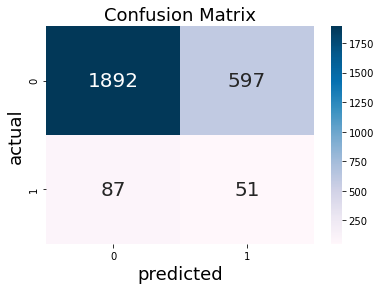

In [91]:
# confusion matrix on train data
evaluation(y_test, y_pred)

In [92]:
preds

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [95]:
#using y_test
preds = best_model.predict(X_test)



In [96]:
len(y_test)

2627

Recall:  0.0
Accuracy:  0.9474685953559193
Precision:  0.0
F1:  0.0


C:\Users\junho\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


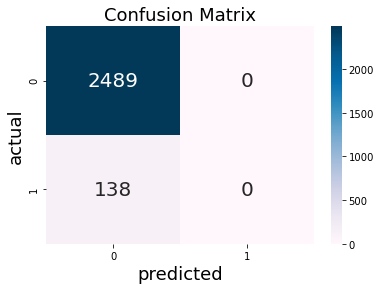

In [97]:
evaluation(y_test, preds)

In [98]:
preds

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [99]:
# preds = best_model.predict(X_test)


In [100]:
# np.set_printoptions(threshold=np.inf)

# preds


In [101]:
y_test

Date
2007-08-07    0
2007-09-12    0
2011-09-16    0
2007-09-24    0
2007-09-06    0
             ..
2007-07-11    0
2007-07-02    0
2007-08-02    0
2013-08-15    0
2007-09-05    0
Name: WnvPresent, Length: 2627, dtype: int64

In [ ]:
sum(sum((value*confusion_mat).values))

Conclusion: 
If X Education uses my model to classify new customers and e-mail those who are classified as potential buyers it can generate an overall expected profit of $70485.

In [ ]:
test

In [ ]:
train